<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase3_DESI_SymbolicValidation_SRLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from astropy.io import fits

# Path to your DESI QSO catalog
desi_path = "/content/drive/MyDrive/CMB Data/QSO_cat_iron_cumulative_v0.fits"

# Open the FITS file
with fits.open(desi_path) as hdul:
    data = hdul[1].data
    print("✅ DESI QSO catalog loaded.")
    print(f"Total entries: {len(data)}\n")
    print("Available columns:\n", data.columns.names)
    print("\nSample entries:")
    print(data[:5])  # Show first 5 rows

✅ DESI QSO catalog loaded.
Total entries: 2182309

Available columns:
 ['TARGETID', 'Z', 'ZERR', 'ZWARN', 'LOCATION', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PROBA_RF', 'FLUX_IVAR_W2', 'MASKBITS', 'CMX_TARGET', 'DESI_TARGET', 'COADD_NUMEXP', 'COADD_EXPTIME', 'SV1_DESI_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET', 'SV1_SCND_TARGET', 'SV2_SCND_TARGET', 'SV3_SCND_TARGET', 'SCND_TARGET', 'TSNR2_LYA', 'TSNR2_QSO', 'DELTA_CHI2_MGII', 'A_MGII', 'SIGMA_MGII', 'B_MGII', 'VAR_A_MGII', 'VAR_SIGMA_MGII', 'VAR_B_MGII', 'Z_RR', 'Z_QN', 'C_LYA', 'C_CIV', 'C_CIII', 'C_MgII', 'C_Hbeta', 'C_Halpha', 'Z_LYA', 'Z_CIV', 'Z_CIII', 'Z_MgII', 'Z_Hbeta', 'Z_Halpha', 'QSO_MASKBITS', 'TILEID', 'LASTNIGHT', 'PETAL_LOC', 'SURVEY', 'PROGRAM', 'MORPHTYPE', 'SPECTYPE']

Sample entries

In [4]:
# --- Extract DESI quasar RA, DEC, and redshift ---
ra_desi = data['TARGET_RA']
dec_desi = data['TARGET_DEC']
z_desi = data['Z']

print(f"✅ Loaded {len(ra_desi)} DESI quasars.")
print(f"Redshift range: z = {np.min(z_desi):.4f} to {np.max(z_desi):.4f}")

✅ Loaded 2182309 DESI quasars.
Redshift range: z = 0.0512 to 6.6558


In [5]:
# Optional redshift filter
mask_z = z_desi < 2.5
ra_desi_z = ra_desi[mask_z]
dec_desi_z = dec_desi[mask_z]

print(f"✅ {len(ra_desi_z)} DESI quasars after z < 2.5 filter.")

✅ 1765708 DESI quasars after z < 2.5 filter.


Computing SRL phase for DESI quasars...
✅ Spiral Resonance Factor (SRF) for DESI: 24062.667607


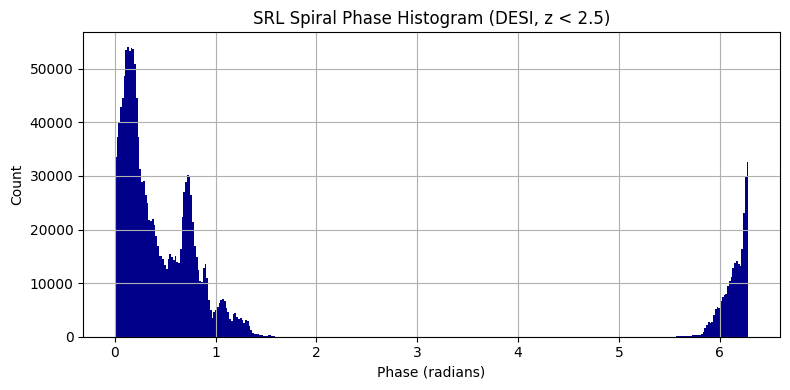

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Spiral phase function ---
def compute_spiral_phase(ra, dec, omega=0.10, n=1, epsilon=1e-3):
    theta = np.radians(ra)  # angular position
    z = dec  # use dec directly or project as needed
    phase = omega * np.log(np.abs(theta) + epsilon) + n * np.radians(z)
    return np.mod(phase, 2 * np.pi)

# --- SRF computation ---
def compute_srf(phases, bins=360):
    hist, _ = np.histogram(phases, bins=bins, range=(0, 2 * np.pi))
    hist_mean = np.mean(hist)
    hist_var = np.var(hist)
    return hist_var / (hist_mean + 1e-8)

# --- Run phase calculation ---
print("Computing SRL phase for DESI quasars...")
phases_desi = compute_spiral_phase(ra_desi_z, dec_desi_z)

# --- Compute SRF ---
srf_desi = compute_srf(phases_desi)
print(f"✅ Spiral Resonance Factor (SRF) for DESI: {srf_desi:.6f}")

# --- Optional: Phase histogram plot ---
plt.figure(figsize=(8, 4))
plt.hist(phases_desi, bins=360, range=(0, 2*np.pi), color='darkblue')
plt.title("SRL Spiral Phase Histogram (DESI, z < 2.5)")
plt.xlabel("Phase (radians)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# --- Encode phase to symbols (A-H based on 8 bins) ---
def encode_phase_to_symbols(phases, alphabet="ABCDEFGH"):
    k = len(alphabet)
    bins = np.linspace(0, 2*np.pi, k+1)
    indices = np.digitize(phases, bins) - 1
    indices = np.clip(indices, 0, k-1)
    return np.array([alphabet[i] for i in indices])

# Encode
symbolic_stream_desi = encode_phase_to_symbols(phases_desi)

# Save for downstream analysis
np.save("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", symbolic_stream_desi)

# Preview
from collections import Counter
counts = Counter(symbolic_stream_desi)
print("✅ Symbolic stream encoded.")
print("Top 8 symbols:", counts)

✅ Symbolic stream encoded.
Top 8 symbols: Counter({np.str_('A'): 1285681, np.str_('H'): 266014, np.str_('B'): 213933, np.str_('C'): 42, np.str_('G'): 38})


In [9]:
from collections import Counter
import math

# --- Shannon Entropy ---
def shannon_entropy(sequence):
    counts = Counter(sequence)
    probs = [count / len(sequence) for count in counts.values()]
    return -sum(p * math.log2(p) for p in probs)

# --- Corrected Lempel-Ziv Complexity ---
def lempel_ziv_complexity(sequence):
    i, k, l = 0, 1, 1
    complexity = 1
    n = len(sequence)
    while True:
        if ''.join(sequence[i:i+l]) == ''.join(sequence[k:k+l]):
            l += 1
            if k + l > n:
                complexity += 1
                break
        else:
            if l == 1:
                k += 1
                if k == n:
                    break
            else:
                i += 1
                if i == k:
                    complexity += 1
                    k += 1
                    i = 0
                l = 1
    return complexity / len(sequence)

# --- Compute and Print ---
H_desi = shannon_entropy(symbolic_stream_desi)
LZC_desi = lempel_ziv_complexity(symbolic_stream_desi)

print(f"✅ Shannon Entropy: {H_desi:.4f} bits")
print(f"✅ Lempel-Ziv Complexity (normalized): {LZC_desi:.5f}")

✅ Shannon Entropy: 1.1143 bits
✅ Lempel-Ziv Complexity (normalized): 0.00037


In [10]:
import numpy as np

# Assuming symbolic_stream_desi was already created in a previous step
# If not, replace this with the correct symbolic stream construction code
symbolic_stream_desi = np.array(symbolic_stream_desi)

# Save to file
np.save("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", symbolic_stream_desi)
print("✅ Symbolic stream for DESI saved.")

✅ Symbolic stream for DESI saved.


✅ Top 10 recurring motifs (length=5):
AAAAA: 1268666
HHHHH: 254935
BBBBB: 207796
HAAAA: 1859
AAAAH: 1847
HHHHA: 1840
AHHHH: 1828
HHAAA: 1492
AAAHH: 1480
AAHHH: 1478


<ipython-input-11-e0b1efd0b8f7>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(freqs), palette="mako")


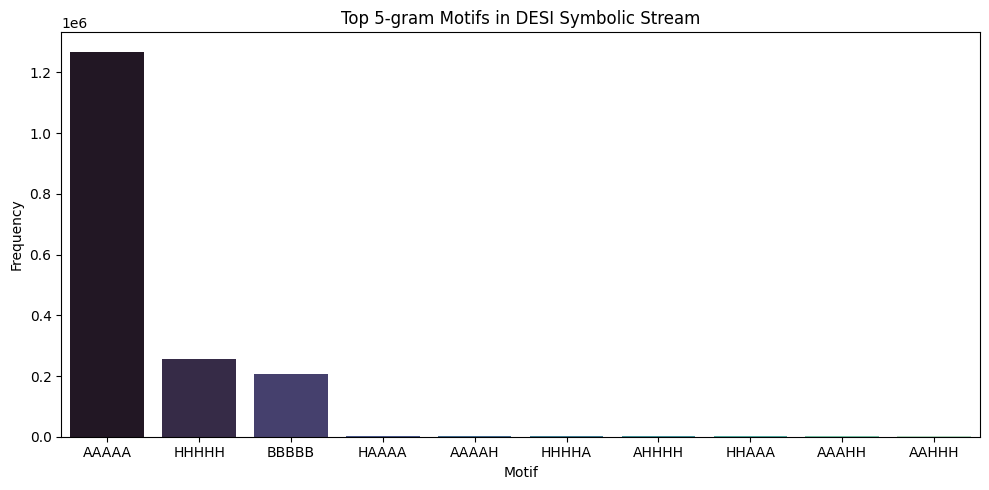

In [11]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load symbolic stream
stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy")

# Extract 5-grams
motifs = [tuple(stream[i:i+5]) for i in range(len(stream) - 4)]
motif_counts = Counter(motifs)

# Display top motifs
top_motifs = motif_counts.most_common(10)
print("✅ Top 10 recurring motifs (length=5):")
for motif, count in top_motifs:
    print(f"{''.join(motif)}: {count}")

# Plot
labels, freqs = zip(*top_motifs)
labels = [''.join(m) for m in labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=list(labels), y=list(freqs), palette="mako")
plt.title("Top 5-gram Motifs in DESI Symbolic Stream")
plt.ylabel("Frequency")
plt.xlabel("Motif")
plt.tight_layout()
plt.show()

100%|██████████| 3531/3531 [00:00<00:00, 5525.18it/s]


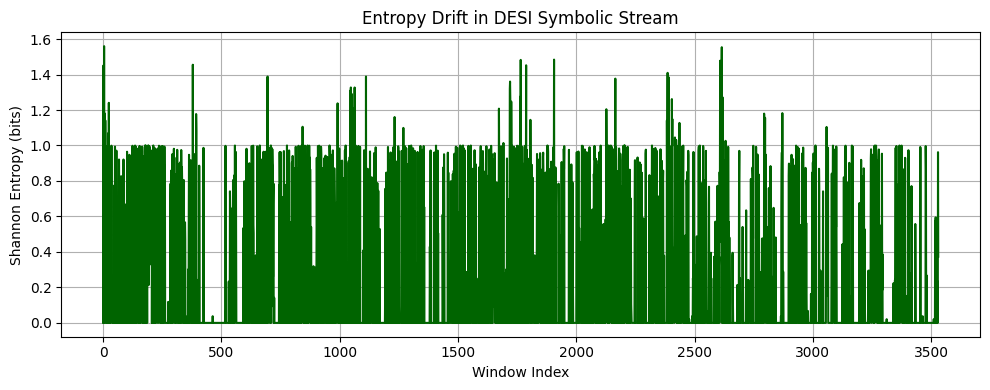

✅ Mean entropy: 0.2558 bits
✅ Std deviation: 0.3792 bits


In [12]:
from tqdm import tqdm

def sliding_entropy(stream, window_size=500):
    entropies = []
    for i in tqdm(range(0, len(stream) - window_size, window_size)):
        window = stream[i:i + window_size]
        counts = Counter(window)
        probs = np.array(list(counts.values())) / window_size
        entropy = -np.sum(probs * np.log2(probs))
        entropies.append(entropy)
    return np.array(entropies)

# Compute
entropy_series_desi = sliding_entropy(stream, window_size=500)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(entropy_series_desi, color="darkgreen")
plt.title("Entropy Drift in DESI Symbolic Stream")
plt.xlabel("Window Index")
plt.ylabel("Shannon Entropy (bits)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Stats
print(f"✅ Mean entropy: {np.mean(entropy_series_desi):.4f} bits")
print(f"✅ Std deviation: {np.std(entropy_series_desi):.4f} bits")

In [13]:
# Re-generate symbolic stream file if lost
np.save("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy", symbolic_stream_desi)

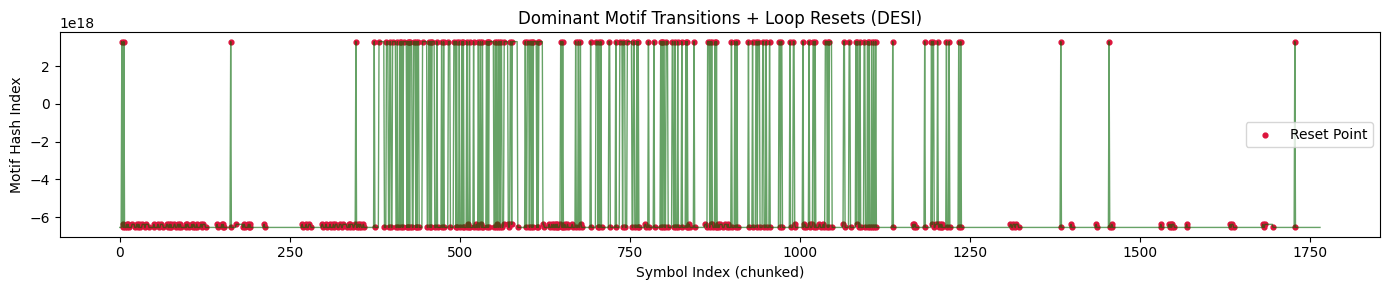

✅ Total unique dominant motifs: 3
✅ Total detected reset points: 455


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Load the DESI symbolic stream
symbolic_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream.npy")

# Parameters
window_size = 1000
reset_threshold = 0.25  # fraction overlap drop that signals reset

# Loop hashing
def motif_hash(motif):
    return hash("".join(motif))

# Track dominant motif hashes
hash_trajectory = []
prev_window = None
for i in range(0, len(symbolic_stream) - window_size, window_size):
    window = symbolic_stream[i:i + window_size]
    counts = Counter(["".join(window[j:j+5]) for j in range(len(window) - 4)])
    dominant = counts.most_common(1)[0][0]
    hash_trajectory.append(motif_hash(dominant))

# Detect resets based on hash changes
reset_indices = []
for i in range(1, len(hash_trajectory)):
    if hash_trajectory[i] != hash_trajectory[i - 1]:
        reset_indices.append(i)

# Save for later inspection
np.save("/content/drive/MyDrive/CMB Data/spiral_reset_points_desi.npy", reset_indices)

# Plot
plt.figure(figsize=(14, 3))
plt.plot(hash_trajectory, color='darkgreen', alpha=0.6, linewidth=1)
plt.scatter(reset_indices, [hash_trajectory[i] for i in reset_indices],
            color='crimson', s=12, label="Reset Point")
plt.xlabel("Symbol Index (chunked)")
plt.ylabel("Motif Hash Index")
plt.title("Dominant Motif Transitions + Loop Resets (DESI)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"✅ Total unique dominant motifs: {len(set(hash_trajectory))}")
print(f"✅ Total detected reset points: {len(reset_indices)}")

100%|██████████| 1765/1765 [00:05<00:00, 330.61it/s]


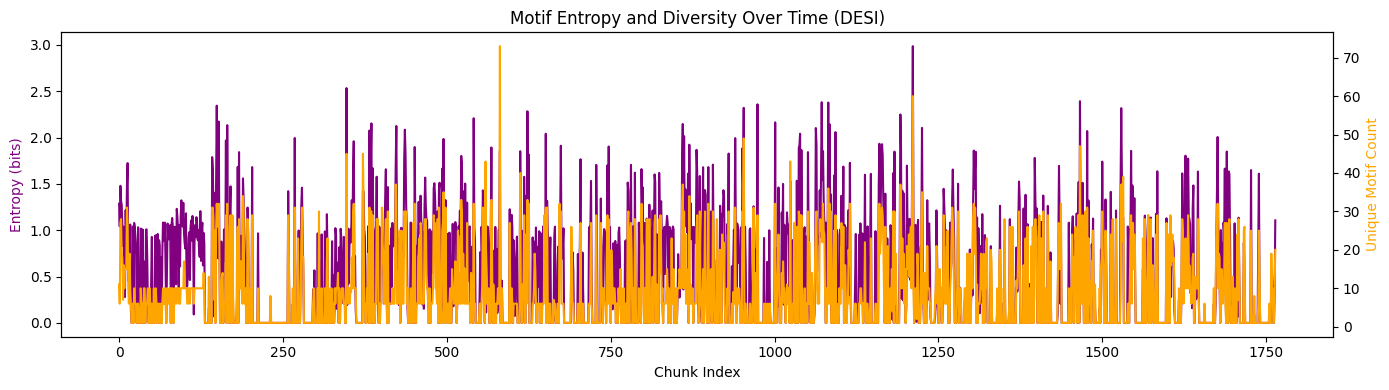

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Uncomment this if not already loaded:
# symbolic_stream_desi = np.load('/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy')

chunk_size = 1000
num_chunks = len(symbolic_stream_desi) // chunk_size

entropy_per_chunk = []
unique_motifs_per_chunk = []

for i in tqdm(range(num_chunks)):
    chunk = symbolic_stream_desi[i * chunk_size : (i + 1) * chunk_size]
    motifs = [''.join(chunk[j:j+5]) for j in range(len(chunk) - 4)]
    motif_counts = Counter(motifs)
    total = sum(motif_counts.values())
    probs = [count / total for count in motif_counts.values()]

    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    entropy_per_chunk.append(entropy)
    unique_motifs_per_chunk.append(len(motif_counts))

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(entropy_per_chunk, color='purple')
ax1.set_ylabel("Entropy (bits)", color='purple')
ax1.set_xlabel("Chunk Index")
ax1.set_title("Motif Entropy and Diversity Over Time (DESI)")

ax2 = ax1.twinx()
ax2.plot(unique_motifs_per_chunk, color='orange')
ax2.set_ylabel("Unique Motif Count", color='orange')

plt.tight_layout()
plt.show()

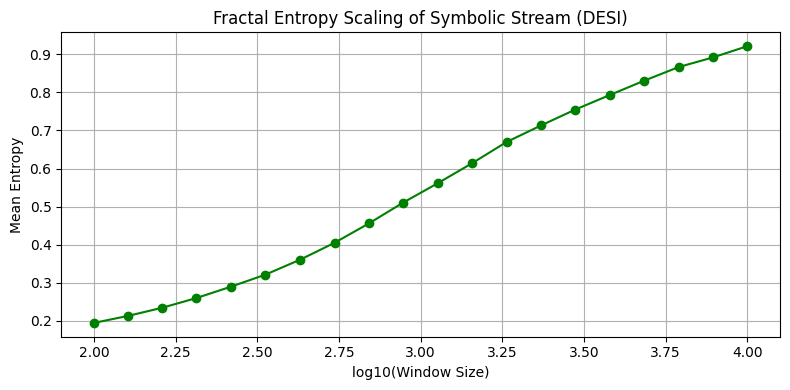

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Define window sizes (powers of 10)
window_sizes = [int(10**x) for x in np.linspace(2, 4, 20)]
mean_entropies = []

for w in window_sizes:
    chunks = [symbolic_stream_desi[i:i+w] for i in range(0, len(symbolic_stream_desi)-w, w)]
    chunk_entropies = []
    for chunk in chunks:
        motifs = [''.join(chunk[j:j+5]) for j in range(len(chunk) - 4)]
        counts = Counter(motifs)
        probs = [c / sum(counts.values()) for c in counts.values()]
        entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        chunk_entropies.append(entropy)
    mean_entropies.append(np.mean(chunk_entropies))

# Plot
plt.figure(figsize=(8,4))
plt.plot(np.log10(window_sizes), mean_entropies, marker='o', color='green')
plt.title("Fractal Entropy Scaling of Symbolic Stream (DESI)")
plt.xlabel("log10(Window Size)")
plt.ylabel("Mean Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()

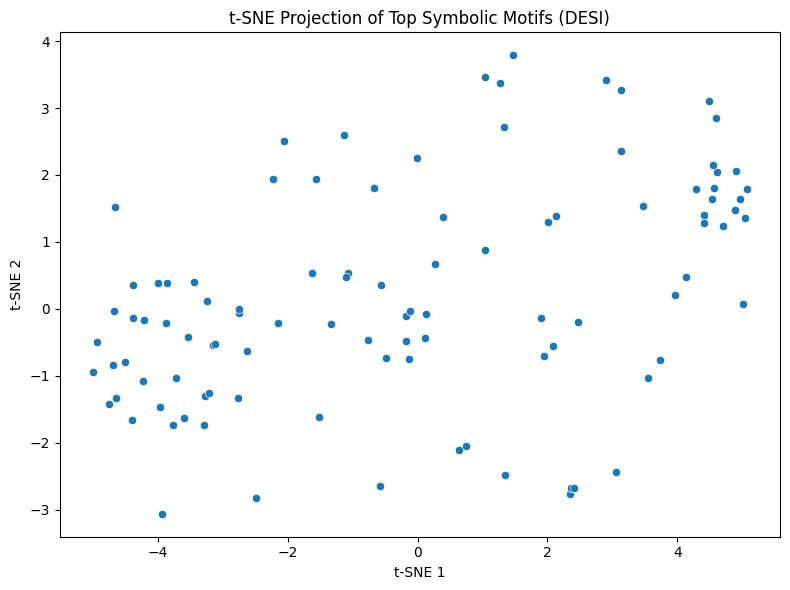

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Select top 100 motifs
motif_counts = Counter([''.join(symbolic_stream_desi[i:i+5]) for i in range(len(symbolic_stream_desi)-4)])
top_motifs = [m for m, _ in motif_counts.most_common(100)]

# Map A–H to integers
symbols = sorted(set(''.join(top_motifs)))
symbol_map = {s: i for i, s in enumerate(symbols)}

# Vectorize motifs
motif_vecs = np.array([[symbol_map[c] for c in motif] for motif in top_motifs])

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
tsne_results = tsne.fit_transform(motif_vecs)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1])
plt.title("t-SNE Projection of Top Symbolic Motifs (DESI)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

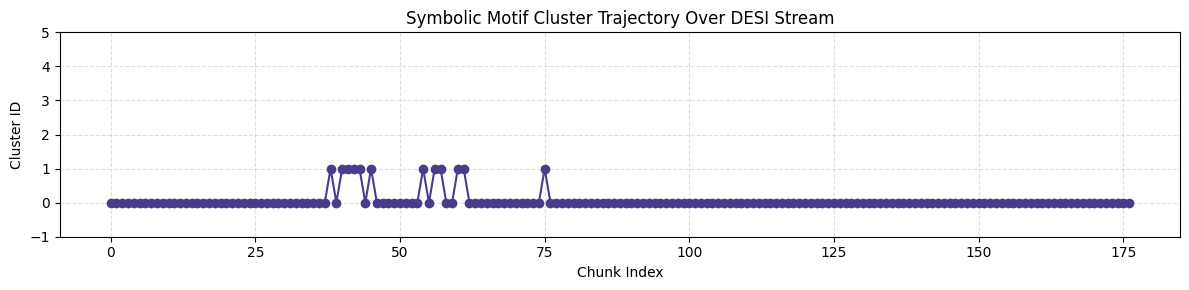

In [19]:
# --- Cluster Motifs and Track Drift Over Time (Fixed) ---

from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns

# Parameters
motif_length = 5
num_clusters = 6
chunk_size = 10000

# Step 1: Extract top motifs (as strings)
all_motifs = ["".join(symbolic_stream_desi[i:i+motif_length]) for i in range(len(symbolic_stream_desi) - motif_length)]
motif_counts = Counter(all_motifs)
top_motifs = [m for m, _ in motif_counts.most_common(100)]

# Step 2: Encode motifs for clustering
symbol_set = sorted(set("".join(top_motifs)))
symbol_map = {s: i for i, s in enumerate(symbol_set)}
motif_vecs = np.array([[symbol_map[c] for c in motif] for motif in top_motifs])

# Step 3: Cluster motifs
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto').fit(motif_vecs)
motif_labels = kmeans.labels_
motif_cluster_map = {motif: label for motif, label in zip(top_motifs, motif_labels)}

# Step 4: Track cluster transitions across stream
chunk_labels = []
for i in range(0, len(symbolic_stream_desi) - motif_length, chunk_size):
    chunk = symbolic_stream_desi[i:i+chunk_size+motif_length]
    motifs = ["".join(chunk[j:j+motif_length]) for j in range(len(chunk) - motif_length)]
    labels = [motif_cluster_map[m] for m in motifs if m in motif_cluster_map]
    if labels:
        most_common_label = Counter(labels).most_common(1)[0][0]
        chunk_labels.append(most_common_label)
    else:
        chunk_labels.append(-1)  # Unknown

# Step 5: Plot trajectory
plt.figure(figsize=(12, 3))
plt.plot(chunk_labels, marker='o', linestyle='-', color='darkslateblue')
plt.title("Symbolic Motif Cluster Trajectory Over DESI Stream")
plt.xlabel("Chunk Index")
plt.ylabel("Cluster ID")
plt.yticks(range(-1, num_clusters))
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

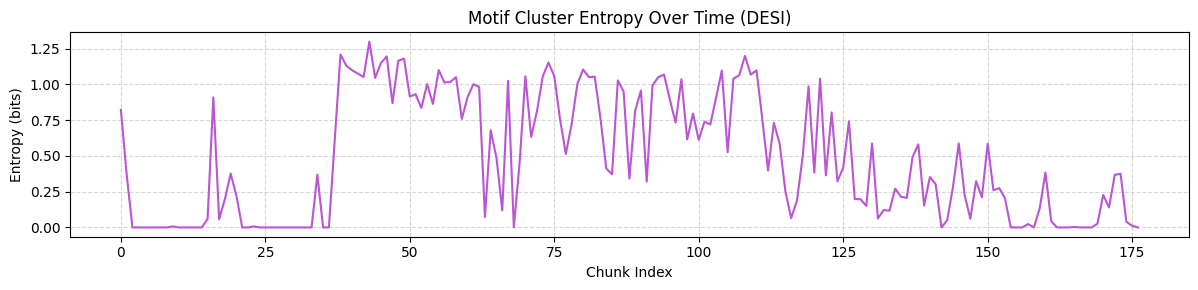

In [20]:
# --- Motif Cluster Entropy Over Time (DESI) ---

def compute_entropy(counts):
    probs = np.array(counts) / np.sum(counts)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

entropy_over_time = []
for i in range(0, len(symbolic_stream_desi) - motif_length, chunk_size):
    chunk = symbolic_stream_desi[i:i+chunk_size+motif_length]
    motifs = ["".join(chunk[j:j+motif_length]) for j in range(len(chunk) - motif_length)]
    labels = [motif_cluster_map[m] for m in motifs if m in motif_cluster_map]
    if labels:
        label_counts = Counter(labels)
        entropy = compute_entropy(list(label_counts.values()))
    else:
        entropy = 0
    entropy_over_time.append(entropy)

# Plot
plt.figure(figsize=(12, 3))
plt.plot(entropy_over_time, color='mediumorchid')
plt.title("Motif Cluster Entropy Over Time (DESI)")
plt.xlabel("Chunk Index")
plt.ylabel("Entropy (bits)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

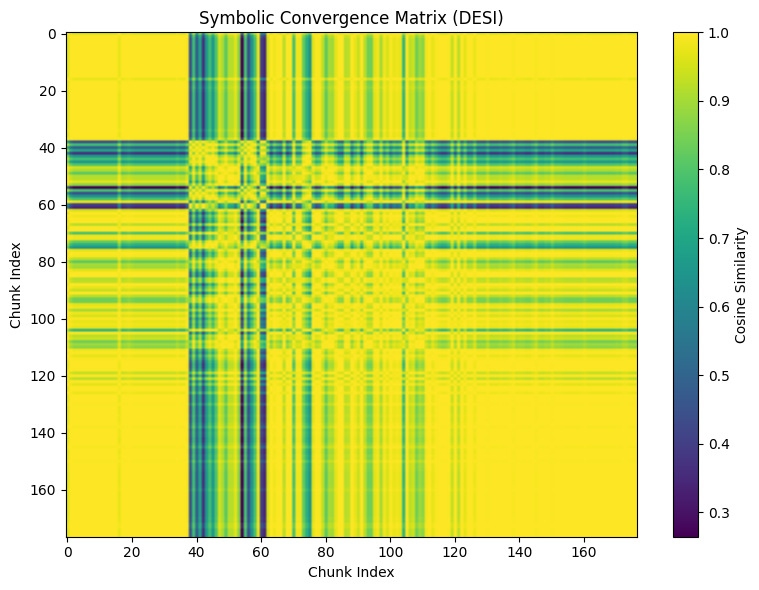

In [21]:
# --- Symbolic Motif Convergence Path (DESI) ---

from sklearn.metrics.pairwise import cosine_similarity

# Extract trajectory of motif cluster vectors
trajectory = []
for i in range(0, len(symbolic_stream_desi) - motif_length, chunk_size):
    chunk = symbolic_stream_desi[i:i+chunk_size+motif_length]
    motifs = ["".join(chunk[j:j+motif_length]) for j in range(len(chunk) - motif_length)]
    vec = np.zeros(num_clusters)
    for m in motifs:
        if m in motif_cluster_map:
            vec[motif_cluster_map[m]] += 1
    norm = np.linalg.norm(vec)
    trajectory.append(vec / norm if norm != 0 else vec)

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(trajectory)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
plt.title("Symbolic Convergence Matrix (DESI)")
plt.xlabel("Chunk Index")
plt.ylabel("Chunk Index")
plt.colorbar(label="Cosine Similarity")
plt.tight_layout()
plt.show()